In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
def nDCG(relevances: np.ndarray, positions: np.ndarray) -> float:
    """Compute Normalized Discounted Cumulative Gain based on:
    - relevances: Numpy Array containing DCG Relevances (5 if booked, 1 if clicked)
    - positions: Numpy Array containing Positions (The display order) """
    
    positions_normalized = np.argsort(positions)
    relevances_ordered = relevances[positions_normalized]
    relevances_sorted = np.sort(relevances)[::-1]
    
    gain = 2 ** relevances_ordered - 1
    ideal_gain = 2 ** relevances_sorted - 1
    
    discount = np.log2(np.arange(len(positions)) + 2)
    
    DCG = np.sum(gain / discount)
    IDCG = np.sum(ideal_gain / discount)
    
    return DCG / IDCG


def nDCG_mean(dataframe: pd.DataFrame) -> float:
    """
    Calculate Mean Normalized Discounted Cumulative Gain on DataFrame
    DataFrame must have fields: [srch_id, relevance, position]
    """
    
    nDCG_sum = 0.0
    
    searches = dataframe.groupby('srch_id')
    
    for name, search in searches:
        nDCG_sum += nDCG(search.relevance.values, search.position.values)
    return nDCG_sum / len(searches)

In [3]:
# Load That Shit (does take a while)
df = pd.read_csv("data/training_set_VU_DM_2014.csv")

In [4]:
# Add Relevance Column to DataFrame
relevance = np.zeros(len(df))
relevance[df['click_bool'] == 1] = 1
relevance[df['booking_bool'] == 1] = 5

df['relevance'] = relevance

In [5]:
# Reorganize DataFrame (a.k.a. throw out competitor info): handy for tweaking/overview?
df = df[[
    # ID
    'srch_id',
    
    # Labels (to predict)
    'position',
    'relevance',
    'click_bool',
    'booking_bool',
    
    # Per Seach Features
    'date_time',
    'site_id',
    'srch_destination_id',
    'srch_length_of_stay',
    'srch_booking_window',
    'srch_adults_count',
    'srch_children_count',
    'srch_room_count',
    'srch_saturday_night_bool',
    'srch_query_affinity_score',
    'orig_destination_distance',
    
    # Property Features
    'price_usd',
    'promotion_flag',
    'prop_country_id',
    'prop_id',
    'prop_starrating',
    'prop_review_score',
    'prop_brand_bool',
    'prop_location_score1',
    'prop_location_score2',
    'prop_log_historical_price',
    
    # Visitor Features
    'visitor_location_country_id',
    'visitor_hist_starrating',
    'visitor_hist_adr_usd',
]]

# Feature Engineering

In [6]:
# Extract Month/Day/Hour from Datetime
dates = pd.DatetimeIndex(df['date_time'])

df['month'] = dates.month
df['day'] = dates.day
df['hour'] = dates.hour

In [7]:
# Highlight Matching Data
df['starrating_diff'] = df.visitor_hist_starrating - df.prop_starrating
df['country_id_match'] = df.visitor_location_country_id == df.prop_country_id
df['user_usd_diff'] = df.price_usd - df.visitor_hist_adr_usd
df['has_booked_before'] = df.visitor_hist_adr_usd.isnull()

In [25]:
df.srch_query_affinity_score = df.srch_query_affinity_score.fillna(df.srch_query_affinity_score.mean())
df.orig_destination_distance = df.orig_destination_distance.fillna(df.orig_destination_distance.mean())

df.prop_location_score2 = df.prop_location_score2.fillna(df.prop_location_score2.min())

df.visitor_hist_adr_usd = df.visitor_hist_adr_usd.fillna(-1)
df.user_usd_diff = df.user_usd_diff.fillna(-1)
df.visitor_hist_starrating = df.visitor_hist_starrating.fillna(-1)
df.starrating_diff = df.starrating_diff.fillna(0)

df.prop_review_score = df.prop_review_score.fillna(df.prop_review_score.min())

In [32]:
# Check Percentage of NaN's per Column

for column in df.columns:
    print("{:50s}{:4.1%} {}".format(column, np.mean(df[column].isnull()), "NaN" if df[column].isnull().any() else ""))

srch_id                                           0.0% 
position                                          0.0% 
relevance                                         0.0% 
click_bool                                        0.0% 
booking_bool                                      0.0% 
date_time                                         0.0% 
site_id                                           0.0% 
srch_destination_id                               0.0% 
srch_length_of_stay                               0.0% 
srch_booking_window                               0.0% 
srch_adults_count                                 0.0% 
srch_children_count                               0.0% 
srch_room_count                                   0.0% 
srch_saturday_night_bool                          0.0% 
srch_query_affinity_score                         0.0% 
orig_destination_distance                         0.0% 
price_usd                                         0.0% 
promotion_flag                                  

In [27]:
def normalize(df: pd.DataFrame, feature: str, with_respect_to: str):
    ft = df[feature]
    ft_mean = df.groupby(with_respect_to)[feature].transform('mean')
    ft_std = df.groupby(with_respect_to)[feature].transform('std')
    
    ft_std[ft_std == 0] = 1    
    return (ft - ft_mean) / ft_std


#Normalize Numerical Features with Respect to Search ID, Property ID and Destination ID
for norm_group in ['srch_id', 'srch_destination_id']:
    for feature in ['price_usd', 'prop_review_score', 'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price']:
        df["{}_{}".format(feature, norm_group)] = normalize(df, feature, norm_group)

In [33]:
# Sample Random Fraction of Searches of DataFrame (To Speed Up Shit)
# (This does take a while though...)
RANDOM_FRACTION = 0.1
selection = df.groupby('srch_id').filter(lambda x: np.random.uniform() < RANDOM_FRACTION)

In [37]:
# Split Train and Test from random selection, again per Search ID
TEST_TRAIN_SPLIT = 0.8

unique_search_ids = np.unique(selection.srch_id)
mask = np.random.uniform(0, 1, len(unique_search_ids)) < TEST_TRAIN_SPLIT

train = selection[selection.srch_id.isin(unique_search_ids[mask])]
test = selection[selection.srch_id.isin(unique_search_ids[~mask])]

train_features = train.loc[:, 'site_id':]
train_labels = train['relevance']

test_features = test.loc[:, 'site_id':]
test_labels = test['relevance']

In [38]:
from sklearn.ensemble import RandomForestRegressor

# Train Regressor on Train Features w.r.t. Train Labels (a.k.a. Relevances)
classifier = RandomForestRegressor()
classifier.fit(train_features, train_labels)

# Predict Relevances
predict_labels = classifier.predict(test_features)

# Through Data to Calculate Score in new DataFrame
# Note that predicted position = - predicted relevance
result = pd.DataFrame({
    'srch_id': test.srch_id,
    'relevance': test.relevance,
    'position': -predict_labels})

print("Prediction:", nDCG_mean(result))


# Throw Random Positions in the Mix, to show we're at least doing better than Random :)
result = pd.DataFrame({
    'srch_id': test.srch_id,
    'relevance': test.relevance,
    'position': np.random.uniform(0, 1, len(test.relevance))
})

print("Random:", nDCG_mean(result))

Prediction: 0.4261000637718814
Random: 0.34342319180515934


<Container object of 40 artists>

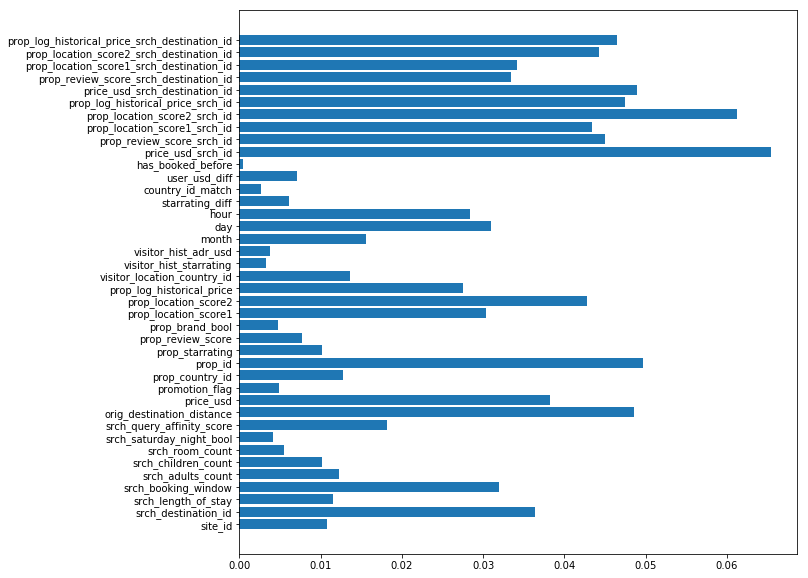

In [39]:
# Plot Feature Importances Graph
fig = plt.figure(figsize=(10, 10))
plt.barh(np.arange(len(test_features.columns)), classifier.feature_importances_,
       tick_label=test_features.columns)